# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [52]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [53]:
import os
from pathlib import Path

import dreaminsg_integrated_model.network_sim_models.interdependencies as interdependencies
import dreaminsg_integrated_model.data.disruptive_scenarios.disrupt_generator as disrupt_generator
import dreaminsg_integrated_model.plots as model_plots
import dreaminsg_integrated_model.simulation_new as simulation

## Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [54]:
network_dir= 'in2'

MAIN_DIR = Path('..')
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/Example_water2.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/Example_power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

# load all infrastructure networks
wn, pn, tn = simulation.load_networks(water_file, power_file, transp_folder)

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\water\Example_water2.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\power\Example_power.json

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.
Iteration 1: gap 0.000305: time 0.000978
Iteration 2: gap 0.000000: time 0.004005


## Create a Networkx graph of the integrated infrastructure network.

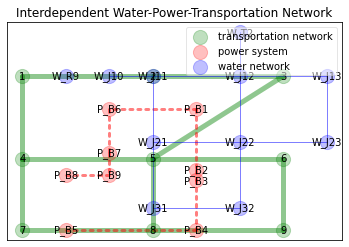

In [55]:
integrated_graph = model_plots.plot_integrated_network(pn, wn, tn, plotting=False)

## Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [56]:
dependency_file = MAIN_DIR/"dreaminsg_integrated_model/data/networks/in2/dependecies.csv"
dependency_table = interdependencies.DependencyTable()

# power-water dependencies
dependency_table = simulation.build_power_water_dependencies(
    dependency_table, dependency_file
)
dependency_table.wp_table.head()

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [57]:
# transportation access interdependencies
dependency_table = simulation.build_transportation_access(
    dependency_table, integrated_graph
)
dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,4,power,Bus,125.00
1,P_B7,5,power,Bus,103.08
2,P_B5,7,power,Bus,100.00
3,P_B4,8,power,Bus,100.00
4,P_B6,2,power,Bus,180.28


## Simulation of interdependent effects using a test scenario
### (a) Scheduling infrastructure disruptions and optimal recovery actions.
Before we run the simulation, we need to specify the simulation parameters and recovery parameters.

In [58]:
curr_loc_crew = 8

Now, we have to create a event table that has all the disruptions and recovery actions scheduled in it. For this first, we read the disruptive scenario file having information only about the disruptive events. The we add the disruptive events to the main **event_table**.

In [59]:
# Setting simulation parameters
sim_step = (
    wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation

# creating test case dataframe
scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/test1/motor_failure_net1.csv"
motor_failure = disrupt_generator.DisruptionAndRecovery(scenario_file, sim_step, curr_loc_crew)

In [60]:
motor_failure.event_table

,time_stamp,components,perf_level,component_state
0,0,P_MP1,100,Functional
1,0,P_L2,100,Functional
2,0,P_LO1,100,Functional
3,0,W_P22,100,Functional
4,15000,P_MP1,25,Service Disrupted
5,6000,P_L2,50,Service Disrupted
6,18000,P_LO1,75,Service Disrupted
7,24000,W_P22,50,Service Disrupted


Now, we identify the optimized recovery strategy (order of restoration/repair) and schedule the recovery actions in the **event_table**. The travel time for the repair crew from current location to the next location is computed using the transportation network model. 

In [61]:
# Simulating repair curves
simulation.schedule_component_repair(motor_failure, integrated_graph, pn, wn, tn)

The optimised repair strategy is to schedule repair of failed components in the following order: ['P_MP1', 'P_LO1', 'P_L2', 'W_P22']

power MP motor Motor
The crew is at 8 at t = 250.0 minutes. It takes 8 minutes to reach nearest node 4, the nearest transportation node from P_MP1.
power LO load Load
The crew is at 4 at t = 1698.0 minutes. It takes 4 minutes to reach nearest node 7, the nearest transportation node from P_LO1.
power L line Line
The crew is at 7 at t = 1882.0 minutes. It takes 8 minutes to reach nearest node 5, the nearest transportation node from P_L2.
water P pipes Pipe
Connected node: W_J22
Nearest node: 6
The crew is at 5 at t = 2070.0 minutes. It takes 4 minutes to reach nearest node 6, the nearest transportation node from W_P22.
All restoration actions are successfully scheduled.


In [62]:
motor_failure.event_table

,time_stamp,components,perf_level,component_state
0,0,P_MP1,100,Functional
1,0,P_L2,100,Functional
2,0,P_LO1,100,Functional
3,0,W_P22,100,Functional
4,6000,P_L2,50,Service Disrupted
5,15000,P_MP1,25,Service Disrupted
6,15480,P_MP1,25,Repairing
7,18000,P_LO1,75,Service Disrupted
8,24000,W_P22,50,Service Disrupted
9,101760.0,P_MP1,25,Repairing


In [63]:
simulation.expand_event_table(motor_failure, sim_step, 10)
motor_failure.event_table.head(20)

,time_stamp,components,perf_level,component_state
0,60.0,P_MP1,100,Functional
1,60.0,P_L2,100,Functional
2,60.0,P_LO1,100,Functional
3,60.0,W_P22,100,Functional
4,6060.0,P_L2,50,Service Disrupted
25,6060.0,P_LO1,100,Functional
26,6060.0,W_P22,100,Functional
24,6060.0,P_MP1,100,Functional
5,15060.0,P_MP1,25,Service Disrupted
27,15060.0,P_L2,50,Service Disrupted


### (b) Simulating the interdependent effects
Now, the integrated network simulation is run with operational parameters of disrupted components fetched from the **event_table**.

In [64]:
time_tracker, power_consump_tracker, water_consump_tracker = simulation.simulate_interdependent_effects(
    motor_failure, dependency_table, pn, wn, tn
)

[60.0, 6060.0, 15060.0, 15540.0, 17520.0, 18060.0, 24060.0, 34980.0, 52440.0, 69900.0, 87360.0, 101820.0, 101940.0, 102180.0, 104820.0, 109140.0, 112860.0, 112980.0, 113460.0, 120180.0, 122280.0, 124140.0, 124260.0, 124500.0, 131460.0, 139740.0, 157200.0, 167580.0, 167700.0, 174660.0, 174900.0]

Simulating network conditions at 60.0 s
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
  time_stamp components perf_level component_state
0       60.0      P_MP1        100      Functional
1       60.0       P_L2        100      Functional
2       60.0      P_LO1        100      Functional
3       60.0      W_P22        100      Functional
Motor operational status:  True
    W_P10  W_P11  W_P12  W_P21  W_P22  W_P31  W_P110  W_P111  W_P112  W_P113  \
0       1      1      1      1      1      1       1       1       1       1   
60      1      1      1      1      1      1       1       1       1       1   

    W_P121  W_P122  W_P22_B  W_WP9  
0        1       1    

### Plot the direct and interdependent effects

In [65]:
location = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/test2"
simulation.write_results(
    time_tracker, power_consump_tracker, water_consump_tracker, location, plotting=False
)

The simulation results successfully saved to ..\dreaminsg_integrated_model\data\disruptive_scenarios\test2


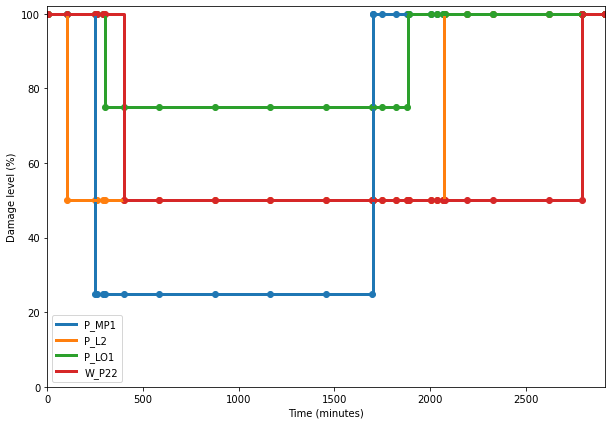

In [66]:
#Plotting repair curves
model_plots.plot_repair_curves(motor_failure, scatter = True)

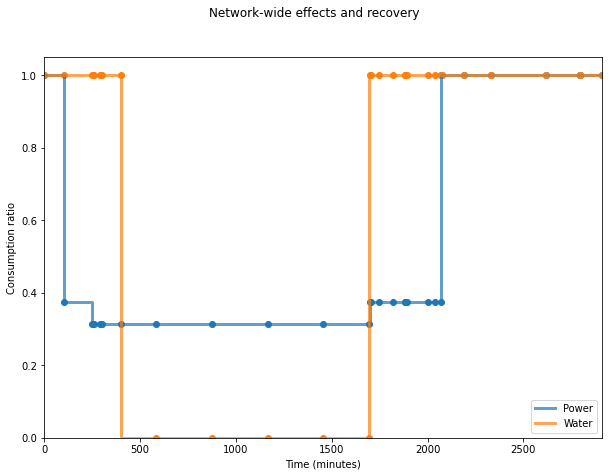

In [68]:
model_plots.plot_interdependent_effects(power_consump_tracker, water_consump_tracker, time_tracker, scatter = True)